# Loading packages

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

# Model loading functions

In [2]:

def create_resnetmodel():
    """
        This fucntion returns the pretrained resnet50 model with the 2 class fc layer
    """

    model = models.resnet18(weights="DEFAULT")
    num_features = model.fc.in_features

    model.fc = nn.Linear(in_features=num_features, out_features=2, bias=True)
    nn.init.xavier_uniform_(model.fc.weight)
    model.fc.bias.data.fill_(0.0)

    # The model weights are frozen except for the fully connected layer
    model = model.requires_grad_(False)
    model.fc.weight.requires_grad_(True)
    model.fc.bias.requires_grad_(True)

    return model

# Data loading functions

In [3]:
def generate_dataset() -> (list, list):
    """
        This function returns the trainset and testset of the CIFAR10 dataset
    """

    generator1 = torch.Generator().manual_seed(42)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset_all = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    testset_all = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    # Filter the dataset to include only 'plane' and 'car' classes
    classes_of_interest = [0, 1] # plane, automobile
    train_dataset = [item for i, item in enumerate(trainset_all) if trainset_all.targets[i] in classes_of_interest]
    test_dataset = [item for i, item in enumerate(testset_all) if testset_all.targets[i] in classes_of_interest]

    return train_dataset, test_dataset

def separate_train_val(trainset: list, val_ratio = 0.2) -> (list, list):
    """
        This function separates the train and validation sets with the given ratio
    """

    validation_size = int(val_ratio*len(trainset))
    train_size = len(trainset) - validation_size
    train_dataset, val_dataset = random_split(trainset, [train_size, validation_size])
    return train_dataset, val_dataset

def create_dataloaders(train_dataset, val_dataset, test_dataset):
    """
        This function creates the dataloaders if the input is not None
    """
    if train_dataset is not None:
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    else:
        train_loader = None
    if val_dataset is not None:
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
    else:
        val_loader = None
    if test_dataset is not None:
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    else:
        test_loader = None

    return train_loader, val_loader, test_loader


# Training function

In [4]:
def train(model, train_loader, val_loader, epochs, optimizer, loss_function) -> (list, list, list, list):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    train_loss_values = []
    train_accuracy_values = []
    val_loss_values = []
    val_accuracy_values = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        model.train()
        for i, data in enumerate(train_loader):

            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            # print(outputs)
            loss = criterion(outputs, labels)
            # print(outputs)
            loss.backward()
            optimizer.step()

            # Calculate training loss
            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = correct / total

        train_loss_values.append(epoch_train_loss)
        train_accuracy_values.append(epoch_train_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], "
            f"Train Loss: {epoch_train_loss:.4f}, "
            f"Train Accuracy: {100 * epoch_train_accuracy:.2f}%")

        if val_loader is not None:

            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs, val_labels)
                    val_running_loss += val_loss.item()
                    _, val_predicted = val_outputs.max(1)
                    val_total += val_labels.size(0)
                    val_correct += val_predicted.eq(val_labels).sum().item()

            epoch_val_loss = val_running_loss / len(val_loader)
            epoch_val_accuracy = val_correct / val_total

            val_loss_values.append(epoch_val_loss)
            val_accuracy_values.append(epoch_val_accuracy)

            print(f"Validation Loss: {epoch_val_loss:.4f}, "
                f"Validation Accuracy: {100 * epoch_val_accuracy:.2f}%")

    print("Finished Training")

    return train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values


def test(model, test_loader) -> float:

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for test_data in test_loader:
            test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
            test_outputs = model(test_inputs)
            _, test_predicted = test_outputs.max(1)
            test_total += test_labels.size(0)
            test_correct += test_predicted.eq(test_labels).sum().item()

    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {100 * test_accuracy:.2f}%")
    return test_accuracy


def plot_results(train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values):

    # Plotting accuracy and loss per epoch
    plt.figure(figsize=(10, 5))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_loss_values, label='Training Loss')
    if val_loss_values is not None:
        plt.plot(range(1, epochs + 1), val_loss_values, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracy_values, label='Training Accuracy')
    if val_accuracy_values is not None:
        plt.plot(range(1, epochs + 1), val_accuracy_values, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
from google.colab import drive

def save_model(model, filename):
    drive.mount('/content/drive')
    torch.save(model.state_dict(), f'/content/drive/MyDrive/DeepHW/ProblemSet3/{filename}')

# Part 1
In this part we only use the cross entropy loss

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


100%|██████████| 170498071/170498071 [00:18<00:00, 9179454.76it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/60], Train Loss: 1.3428, Train Accuracy: 47.48%
Validation Loss: 1.1302, Validation Accuracy: 51.25%
Epoch [2/60], Train Loss: 1.1106, Train Accuracy: 51.25%
Validation Loss: 0.9778, Validation Accuracy: 56.30%
Epoch [3/60], Train Loss: 0.9427, Train Accuracy: 56.38%
Validation Loss: 0.8587, Validation Accuracy: 60.35%
Epoch [4/60], Train Loss: 0.8324, Train Accuracy: 60.62%
Validation Loss: 0.7637, Validation Accuracy: 64.25%
Epoch [5/60], Train Loss: 0.7428, Train Accuracy: 64.96%
Validation Loss: 0.6937, Validation Accuracy: 66.75%
Epoch [6/60], Train Loss: 0.6726, Train Accuracy: 68.09%
Validation Loss: 0.6371, Validation Accuracy: 70.15%
Epoch [7/60], Train Loss: 0.6254, Train Accuracy: 71.21%
Validation Loss: 0.5982, Validation Accuracy: 72.45%
Epoch [8/60], Train Loss: 0.5957, Train Accuracy: 72.74%
Validation Loss: 0.5704, Validation Accuracy: 73.30%
Epoch [9/60], Train Loss: 0.557

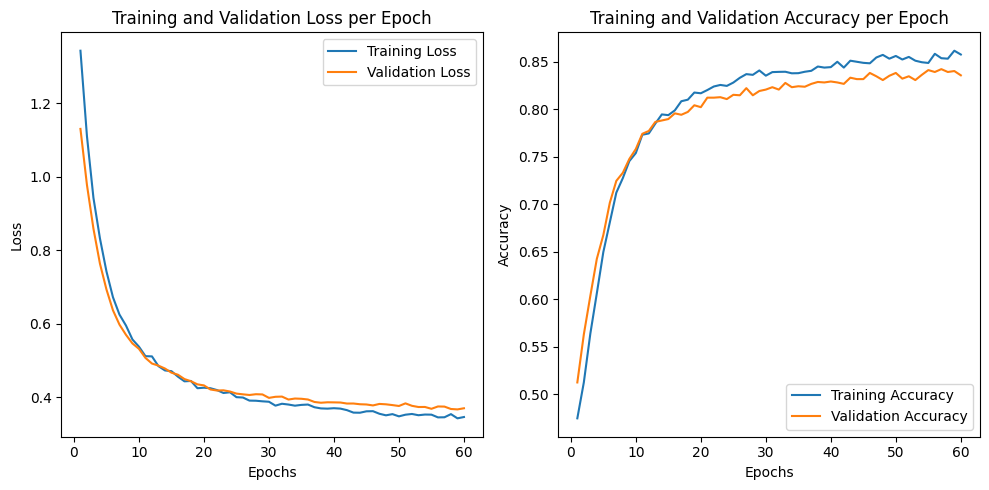

In [6]:

model = create_resnetmodel()
train_data, test_dataset = generate_dataset()
train_dataset, val_dataset = separate_train_val(train_data, val_ratio = 0.2)
train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset)

epochs = 60
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.005)
criterion = nn.CrossEntropyLoss()
train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values = train(model,
                                                                                       train_loader,
                                                                                       val_loader,
                                                                                       epochs,
                                                                                       optimizer,
                                                                                       criterion)
test_accuracy = test(model, test_loader)
plot_results(train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values)




In [7]:
save_model(model, "q1_part1.pth")

Mounted at /content/drive


# Triplet Loss

In [6]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import random

In [7]:
# Refining the architecture

def create_feature_extractor():
    """
        Removes the fc layer from the resnet model
    """
    model = create_resnetmodel()

    # Remove the fc layer in the end of the model to create the feature extractor
    num_features = model.fc.in_features

    model.fc = nn.Identity()
    model = model.requires_grad_(True)

    return model

## Dataset

In [14]:
class TripletDataset(Dataset):
    def __init__(self, dataset, with_labels=False):
        self.dataset = dataset
        self.with_labels = with_labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.dataset[idx]

        # Select a positive sample from the same class
        positive_img = random.choice([data[0] for data in self.dataset if data[1] == anchor_label])

        # Select a negative sample from a different class
        negative_img = random.choice([data[0] for data in self.dataset if data[1] != anchor_label])

        if not self.with_labels:
            return anchor_img, positive_img, negative_img
        else:
            return anchor_img, positive_img, negative_img, anchor_label

def create_triplet_train_loader(with_labels=False):
    train_data, test_dataset = generate_dataset()

    # Create a dataset for triplet loss
    triplet_dataset = TripletDataset(train_data, with_labels=with_labels)

    # Create a dataloader for triplet loss
    triplet_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)
    return triplet_loader

## Training the feature extractor

In [9]:
def train_feature_extractor(feature_extractor, triplet_loader, epochs, optimizer, loss_function):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    feature_extractor.to(device)
    feature_extractor.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(triplet_loader):
            anchor, positive, negative = data[0].to(device), data[1].to(device), data[2].to(device)

            optimizer.zero_grad()

            # Forward pass
            output_anchor = feature_extractor(anchor)
            output_positive = feature_extractor(positive)
            output_negative = feature_extractor(negative)

            loss = triplet_loss(output_anchor, output_positive, output_negative)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], "
                f"Loss: {running_loss / len(triplet_loader):.4f}")
        running_loss = 0.0

    print("Finished Training with Triplet Loss")


# Train the feature extractor

In [9]:
model = create_feature_extractor()
triplet_dataloader = create_triplet_train_loader()

epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.005)
triplet_loss = nn.TripletMarginLoss()
train_feature_extractor(model, triplet_dataloader, epochs, optimizer, triplet_loss)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.4MB/s]


100%|██████████| 170498071/170498071 [00:02<00:00, 66817347.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/10], Loss: 0.9618
Epoch [2/10], Loss: 0.3272
Epoch [3/10], Loss: 0.2170
Epoch [4/10], Loss: 0.1807
Epoch [5/10], Loss: 0.1596
Epoch [6/10], Loss: 0.1174
Epoch [7/10], Loss: 0.0995
Epoch [8/10], Loss: 0.0961
Epoch [9/10], Loss: 0.0589
Epoch [10/10], Loss: 0.0608
Finished Training with Triplet Loss


# Training the complete model

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/60], Train Loss: 0.7678, Train Accuracy: 57.66%
Validation Loss: 0.6480, Validation Accuracy: 62.15%
Epoch [2/60], Train Loss: 0.5488, Train Accuracy: 68.31%
Validation Loss: 0.4654, Validation Accuracy: 73.45%
Epoch [3/60], Train Loss: 0.4029, Train Accuracy: 78.56%
Validation Loss: 0.3409, Validation Accuracy: 82.45%
Epoch [4/60], Train Loss: 0.3014, Train Accuracy: 85.89%
Validation Loss: 0.2641, Validation Accuracy: 88.55%
Epoch [5/60], Train Loss: 0.2331, Train Accuracy: 91.19%
Validation Loss: 0.2078, Validation Accuracy: 92.85%
Epoch [6/60], Train Loss: 0.1926, Train Accuracy: 93.75%
Validation Loss: 0.1668, Validation Accuracy: 95.55%
Epoch [7/60], Train Loss: 0.1577, Train Accuracy: 95.86%
Validation Loss: 0.1421, Validation Accuracy: 96.40%
Epoch [8/60], Train Loss: 0.1362, Train Accuracy: 96.83%
Validation Loss: 0.1208, Validation Accuracy: 97.70%
Epoch [9/60], Train Loss: 0.1186, Train Accu

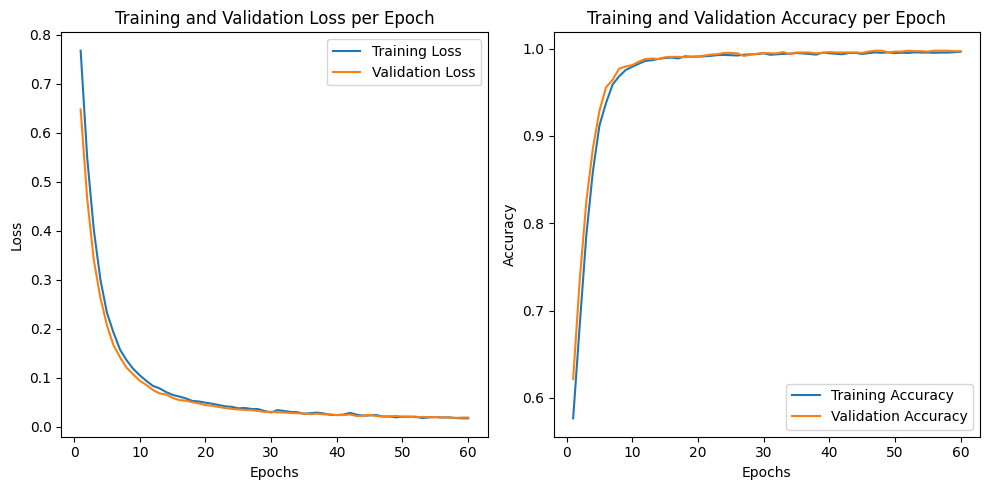

In [14]:
def create_from_feat_extractor(model):

    sample_model = models.resnet18(weights="DEFAULT")
    num_features = sample_model.fc.in_features

    model.fc = nn.Linear(in_features=num_features, out_features=2, bias=True)
    nn.init.xavier_uniform_(model.fc.weight)
    model.fc.bias.data.fill_(0.0)

    model = model.requires_grad_(False)
    model.fc.weight.requires_grad_(True)
    model.fc.bias.requires_grad_(True)
    return model

model = create_from_feat_extractor(model)
train_data, test_dataset = generate_dataset()
train_dataset, val_dataset = separate_train_val(train_data, val_ratio = 0.2)
train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset)

epochs = 60
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.005)
criterion = nn.CrossEntropyLoss()
train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values = train(model,
                                                                                       train_loader,
                                                                                       val_loader,
                                                                                       epochs,
                                                                                       optimizer,
                                                                                       criterion)
test_accuracy = test(model, test_loader)
plot_results(train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values)

In [15]:
save_model(model, "q1_part2.pth")

Mounted at /content/drive


# Part 3

In [10]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import random

In [11]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.feature_extractor = models.resnet18(weights="DEFAULT")
        num_features = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Identity()

        self.classifier = nn.Linear(in_features=num_features, out_features=2, bias=True)
        nn.init.xavier_uniform_(self.classifier.weight)
        self.classifier.bias.data.fill_(0.0)

    def forward(self, x):
        features = self.feature_extractor(x)
        out = self.classifier(features)
        return features, out

In [24]:
def train_2_loss_functions(model, triplet_loader, epochs, optimizer, loss_func_feat_extractor, loss_func_class):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    train_loss_values = []
    train_accuracy_values = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(triplet_loader):
            anchor, positive, negative, labels = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)

            optimizer.zero_grad()

            # Forward pass
            output_anchor, predictions = model(anchor)
            output_positive, _ = model(positive)
            output_negative, _ = model(negative)

            loss = loss_func_feat_extractor(output_anchor, output_positive, output_negative) + loss_func_class(predictions, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = predictions.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_train_loss = running_loss / len(triplet_loader)
        epoch_train_accuracy = correct / total

        train_loss_values.append(epoch_train_loss)
        train_accuracy_values.append(epoch_train_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], "
            f"Train Loss: {epoch_train_loss:.4f}, "
            f"Train Accuracy: {100 * epoch_train_accuracy:.2f}%")


    print("Finished Training with Triplet Loss and cross entropy loss")

    return train_loss_values, train_accuracy_values

def test_2_criteria(model, test_loader) -> float:

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for test_data in test_loader:
            test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
            _, test_outputs = model(test_inputs)
            _, test_predicted = test_outputs.max(1)
            test_total += test_labels.size(0)
            test_correct += test_predicted.eq(test_labels).sum().item()

    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {100 * test_accuracy:.2f}%")
    return test_accuracy

In [23]:
model = CustomModel()

triplet_dataloader = create_triplet_train_loader(with_labels=True)
_, test_dataset = generate_dataset()
_, _, test_loader = create_dataloaders(None, None, test_dataset)

epochs = 8
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.005)
triplet_loss = nn.TripletMarginLoss()
criterion = nn.CrossEntropyLoss()
train_loss_values, train_accuracy_values = train_2_loss_functions(model,
                                                                  triplet_dataloader,
                                                                  epochs,
                                                                  optimizer,
                                                                  triplet_loss,
                                                                  criterion)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/8], Train Loss: 1.2409, Train Accuracy: 89.56%
Epoch [2/8], Train Loss: 0.4503, Train Accuracy: 95.57%
Epoch [3/8], Train Loss: 0.2881, Train Accuracy: 97.12%
Epoch [4/8], Train Loss: 0.2019, Train Accuracy: 98.24%
Epoch [5/8], Train Loss: 0.1363, Train Accuracy: 98.89%
Epoch [6/8], Train Loss: 0.0833, Train Accuracy: 99.34%
Epoch [7/8], Train Loss: 0.1028, Train Accuracy: 99.03%
Epoch [8/8], Train Loss: 0.0862, Train Accuracy: 99.28%
Finished Training with Triplet Loss and cross entropy loss


AttributeError: ignored

Test Accuracy: 96.80%


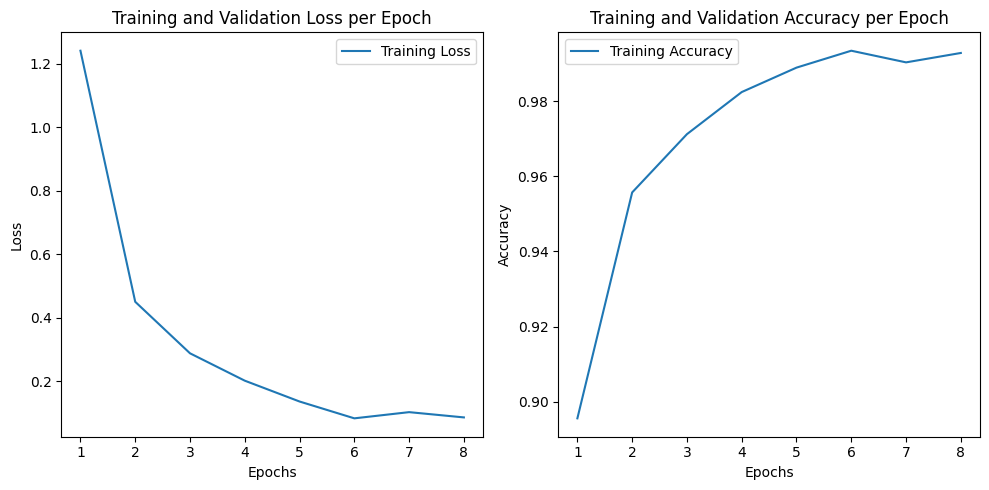

In [26]:
test_accuracy = test_2_criteria(model, test_loader)
plot_results(train_loss_values, train_accuracy_values, None, None)

In [27]:
save_model(model, "q1_part3.pth")

Mounted at /content/drive
